# Import Libraries



In [ ]:
import string
import numpy as np
import pandas as pd 
from numpy import array
from pickle import load
from PIL import Image
import pickle
from collections import Counter

import matplotlib.pyplot as plt
import keras
import sys, time, os, warnings 
warnings.filterwarnings("ignore")
import re

import tensorflow as tf
from tqdm import tqdm

from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, BatchNormalization
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.applications.vgg16 import VGG16, preprocess_input

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Load data and convert to dataframe

In [ ]:
image_path = "../input/roastme6k/image_data"
dir_Flickr_text = "../input/roastme6k/token.txt"

jpgs = os.listdir(image_path)
print("Total Images in Dataset = {}".format(len(jpgs)))

Total Images in Dataset = 11958


In [ ]:
file = open(dir_Flickr_text,'r')
text = file.read()
file.close()

datatxt = []
for line in text.split('\n'):
    col = line.split('\t')
    if len(col) == 1:
        continue
    w = col[0].split("#")
    datatxt.append(w + [col[1].lower()])

data = pd.DataFrame(datatxt,columns=["filename","index","caption"])
data = data.reindex(columns =['index','filename','caption'])



uni_filenames = np.unique(data.filename.values)
data.head()

,index,filename,caption
0,1,k6d9vq.jpg,i could fry enough schnitzel to feed a family ...
1,2,k6d9vq.jpg,i see after your parents split the ends of you...
2,3,k6d9vq.jpg,belsnickel judges you as impish
3,4,k6d9vq.jpg,jim carrie s tiktok obsessed sister
4,5,k6d9vq.jpg,your eyebrows plot a graph of your forward loo...


# Visualizations

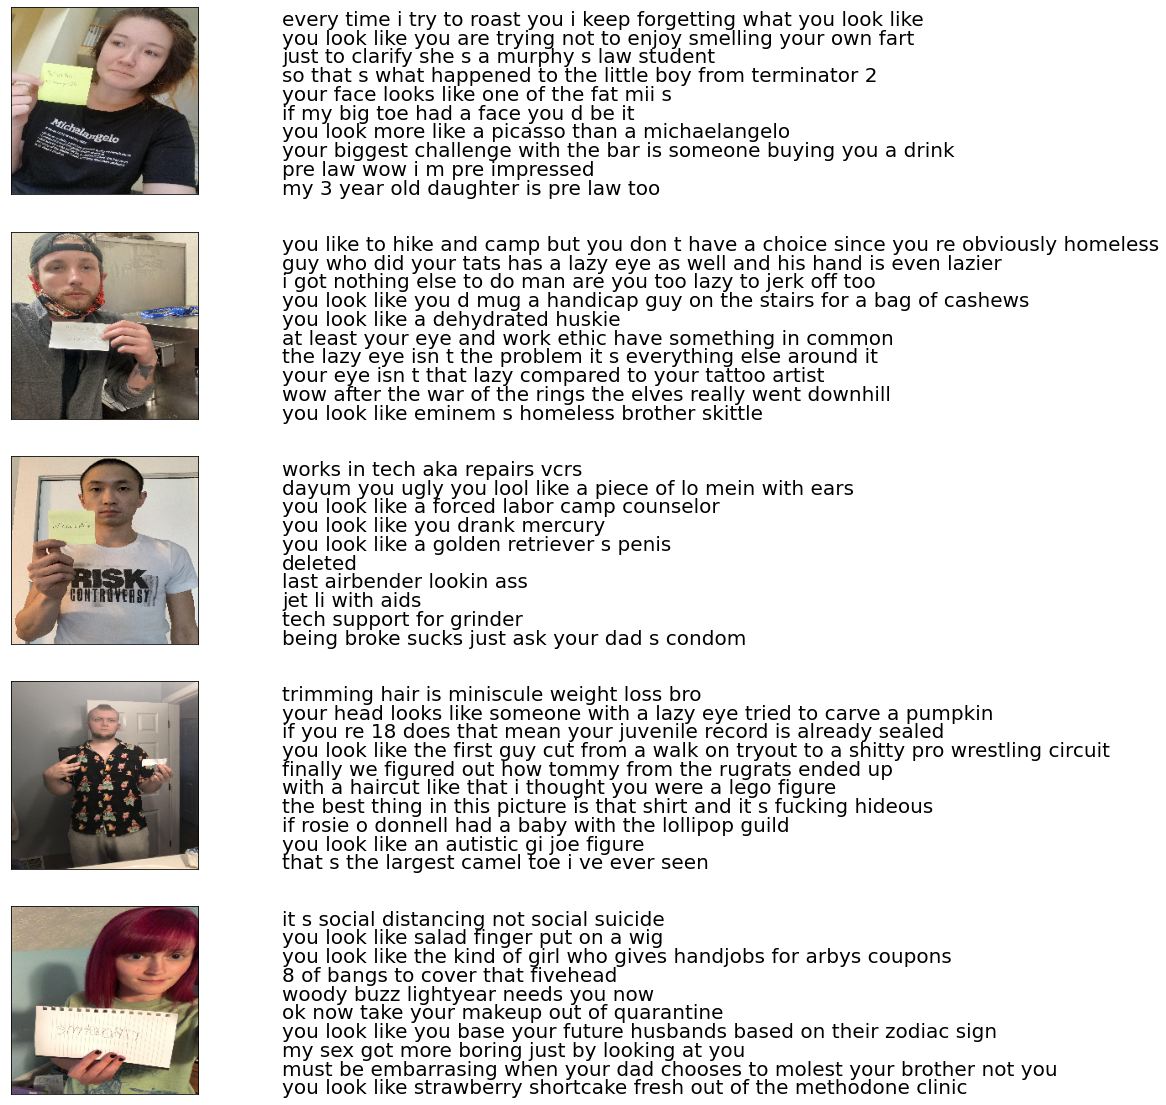

In [ ]:
from keras.preprocessing.image import load_img, img_to_array

npic = 5
npix = 224
target_size = (npix,npix,3)

count = 1
fig = plt.figure(figsize=(10,20))
for jpgfnm in uni_filenames[25:30]:
    filename = image_path + '/' + jpgfnm
    captions = list(data["caption"].loc[data["filename"]==jpgfnm].values)
    image_load = load_img(filename, target_size=target_size)
    
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1
    
    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(captions))
    for i, caption in enumerate(captions):
        ax.text(0,i,caption,fontsize=20)
    count += 1
plt.show()

In [ ]:
def df_word(data):
    vocabulary = []
    for txt in data.caption.values:
        vocabulary.extend(txt.split())
    print('Vocabulary Size: %d' % len(set(vocabulary)))
    ct = Counter(vocabulary)
    appen_1 = []
    appen_2 = []
    for i in ct.keys():
        appen_1.append(i)
    for j in ct.values():
        appen_2.append(j)
    data = {"word":appen_1 , "count":appen_2}
    dfword = pd.DataFrame(data)
    dfword = dfword.sort_values(by='count', ascending=False)
    dfword = dfword.reset_index()[["word","count"]]
    return(dfword)
dfword = df_word(data)

Vocabulary Size: 26211


In [ ]:
dfword.head(10)

,word,count
0,you,33461
1,the,18861
2,a,18527
3,your,15858
4,like,13377
5,to,10193
6,look,9951
7,i,8569
8,of,7941
9,that,6858


In [ ]:
dfword.tail(10)

,word,count
26201,followink,1
26202,fucknotyou,1
26203,railways,1
26204,obsessively,1
26205,fuckdoll,1
26206,rams,1
26207,ewes,1
26208,coxbury,1
26209,tenement,1
26210,llers,1


In [ ]:
vocabulary = []
for txt in data.caption.values:
    vocabulary.extend(txt.split())
print('Vocabulary Size: %d' % len(set(vocabulary)))
ct = Counter(vocabulary)
ct.keys()

Vocabulary Size: 26211


dict_keys(['i', 'could', 'fry', 'enough', 'schnitzel', 'to', 'feed', 'a', 'family', 'of', '12', 'with', 'all', 'the', 'oil', 'in', 'your', 'hair', 'see', 'after', 'parents', 'split', 'ends', 'are', 'following', 'suit', 'belsnickel', 'judges', 'you', 'as', 'impish', 'jim', 'carrie', 's', 'tiktok', 'obsessed', 'sister', 'eyebrows', 'plot', 'graph', 'forward', 'looking', 'ratings', 'on', 'looks', 'was', 'that', 'receipt', 'for', 'plan', 'b', 'because', 'he', 'wasn', 't', 'there', 'when', 'woke', 'up', 'its', 'spelled', 'w', 'rst', 'main', 'cause', 'divorce', 'deleted', 'did', 'one', 'them', 'take', 'upper', 'lip', 'parting', 'gift', '26y', 'old', 'start', 'counting', 'down', 'years', 'from', '100', 'were', 'born', '26', 'holy', 'christ', 'why', 'do', 'look', 'like', 've', 'had', '3', 'bankruptcies', 'and', '2', 'divorces', 'is', '90', 'gap', 'sweater', 'those', 'teeth', 'd', 'say', 'only', 'game', 'ready', 'scrabble', 'thing', 're', 'developing', 'cancer', 'npc', 'who', 'wants', 'fight', 

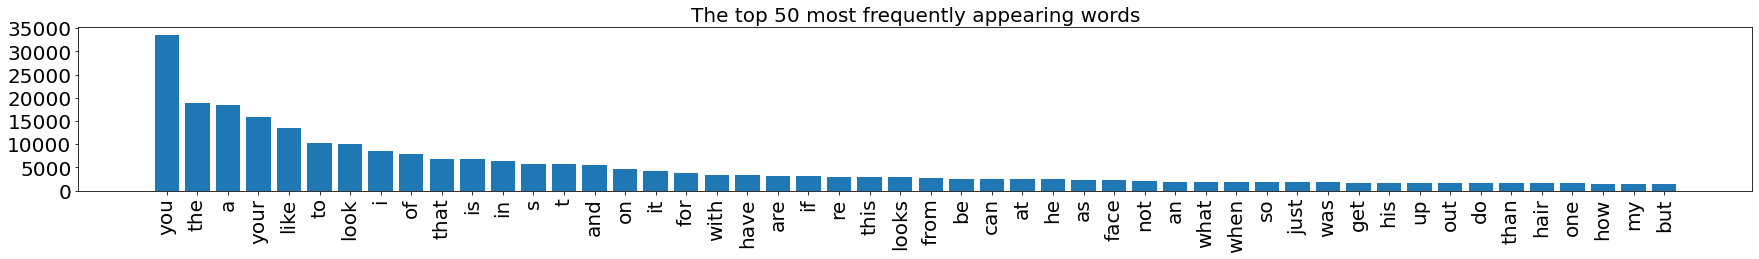

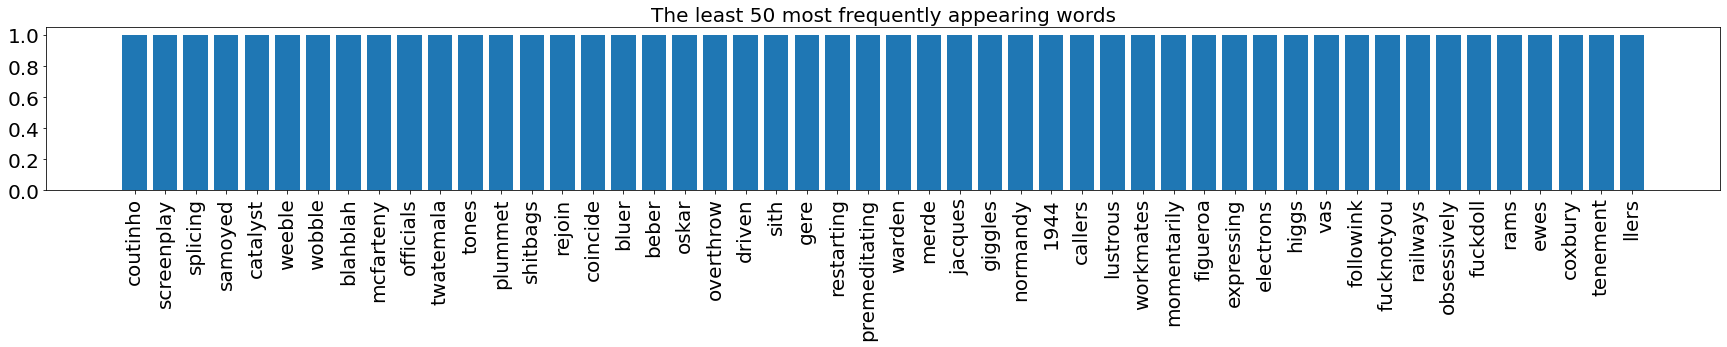

In [ ]:
topn = 50

def plthist(dfsub, title="The top 50 most frequently appearing words"):
    plt.figure(figsize=(30,3))
    plt.bar(dfsub.index,dfsub["count"])
    plt.yticks(fontsize=20)
    plt.xticks(dfsub.index,dfsub["word"],rotation=90,fontsize=20)
    plt.title(title,fontsize=20)
    plt.show()

plthist(dfword.iloc[:topn,:],
        title="The top 50 most frequently appearing words")
plthist(dfword.iloc[-topn:,:],
        title="The least 50 most frequently appearing words")

In [ ]:
vocabulary = []
for txt in data.caption.values:
    vocabulary.extend(txt.split())
print('Vocabulary Size: %d' % len(set(vocabulary)))

Vocabulary Size: 26211


In [ ]:
img = data["filename"].tolist()
caption = data["caption"].tolist()
print(f"len(img) : {len(img)}")
print(f"len(caption) : {len(caption)}")

len(img) : 59790
len(caption) : 59790


# Pre Processing

In [ ]:
# To remove punctuations
def remove_punctuation(text_original):
    text_no_punctuation = text_original.translate(string.punctuation)
    return(text_no_punctuation)

# To remove single characters
def remove_single_character(text):
    text_len_more_than1 = ""
    for word in text.split():
        if len(word) > 1:
            text_len_more_than1 += " " + word
    return(text_len_more_than1)

In [ ]:
def text_clean(text_original):
    text = remove_punctuation(text_original)
    text = remove_single_character(text)
    return(text)
    
for i, caption in enumerate(data.caption.values):
    newcaption = text_clean(caption)
    data["caption"].iloc[i] = newcaption

In [ ]:
PATH ="../input/roastme6k/image_data/"
all_captions = []

for caption  in data["caption"].astype(str):
    caption = '<start> ' + caption+ ' <end>'
    all_captions.append(caption)
all_captions[:10]

['<start>  could fry enough schnitzel to feed family of 12 with all the oil in your hair <end>',
 '<start>  see after your parents split the ends of your hair are following suit <end>',
 '<start>  belsnickel judges you as impish <end>',
 '<start>  jim carrie tiktok obsessed sister <end>',
 '<start>  your eyebrows plot graph of your forward looking ratings on looks <end>',
 '<start>  was that receipt for plan because he wasn there when you woke up <end>',
 '<start>  its spelled rst <end>',
 '<start>  you are the main cause for your parents divorce <end>',
 '<start>  deleted <end>',
 '<start>  did one of them take your upper lip as parting gift <end>']

In [ ]:
all_img_name_vector = []

for annot in data["filename"]:
    full_image_path = PATH + annot

    all_img_name_vector.append(full_image_path)
all_img_name_vector[:10]

['../input/roastme6k/image_data/k6d9vq.jpg',
 '../input/roastme6k/image_data/k6d9vq.jpg',
 '../input/roastme6k/image_data/k6d9vq.jpg',
 '../input/roastme6k/image_data/k6d9vq.jpg',
 '../input/roastme6k/image_data/k6d9vq.jpg',
 '../input/roastme6k/image_data/k6d9vq.jpg',
 '../input/roastme6k/image_data/k6d9vq.jpg',
 '../input/roastme6k/image_data/k6d9vq.jpg',
 '../input/roastme6k/image_data/k6d9vq.jpg',
 '../input/roastme6k/image_data/k6d9vq.jpg']

In [ ]:
print(f"len(all_img_name_vector) : {len(all_img_name_vector)}")
print(f"len(all_captions) : {len(all_captions)}")

len(all_img_name_vector) : 59790
len(all_captions) : 59790


In [ ]:
def data_limiter(num,total_captions,all_img_name_vector):
  train_captions, img_name_vector = shuffle(total_captions,all_img_name_vector,random_state=1)
  train_captions = train_captions[:num]
  img_name_vector = img_name_vector[:num]
  return train_captions,img_name_vector

In [ ]:
train_captions,img_name_vector = data_limiter(50000,all_captions,all_img_name_vector)

In [ ]:
print(f"len(all_img_name_vector) : {len(img_name_vector)}")
print(f"len(all_captions) : {len(train_captions)}")

len(all_img_name_vector) : 50000
len(all_captions) : 50000


In [ ]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

# Define CNN Architecture

In [ ]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
# Get unique images
encode_train = sorted(set(img_name_vector))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

# Split into train and test

In [ ]:
top_k = 5000

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

train_seqs = tokenizer.texts_to_sequences(train_captions)
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')
cap_vector.shape

(50000, 22)

In [ ]:
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,
                                                                    cap_vector,
                                                                    test_size=0.2,
                                                                    random_state=0)

In [ ]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(40000, 40000, 10000, 10000)

In [ ]:
BATCH_SIZE = 128
BUFFER_SIZE = 1000
num_steps = len(img_name_train) // BATCH_SIZE

In [ ]:
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Positional Encoding and Masking

In [ ]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [ ]:
def positional_encoding_1d(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
  pos_encoding = angle_rads[np.newaxis, ...]
    
  return tf.cast(pos_encoding, dtype=tf.float32)

In [ ]:
def positional_encoding_2d(row,col,d_model):
  assert d_model % 2 == 0
  row_pos = np.repeat(np.arange(row),col)[:,np.newaxis]
  col_pos = np.repeat(np.expand_dims(np.arange(col),0),row,axis=0).reshape(-1,1)
  angle_rads_row = get_angles(row_pos,np.arange(d_model//2)[np.newaxis,:],d_model//2)
  angle_rads_col = get_angles(col_pos,np.arange(d_model//2)[np.newaxis,:],d_model//2)

  angle_rads_row[:, 0::2] = np.sin(angle_rads_row[:, 0::2])
  angle_rads_row[:, 1::2] = np.cos(angle_rads_row[:, 1::2])
  angle_rads_col[:, 0::2] = np.sin(angle_rads_col[:, 0::2])
  angle_rads_col[:, 1::2] = np.cos(angle_rads_col[:, 1::2])
  pos_encoding = np.concatenate([angle_rads_row,angle_rads_col],axis=1)[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)


In [ ]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  return seq[:, tf.newaxis, tf.newaxis, :] 

In [ ]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

# Scaled and Multi Head Attention

In [ ]:
def scaled_dot_product_attention(q, k, v, mask):

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
   
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
 
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)  

  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model
    
    assert d_model % self.num_heads == 0
    
    self.depth = d_model // self.num_heads
    
    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)
    
    self.dense = tf.keras.layers.Dense(d_model)
        
  def split_heads(self, x, batch_size):
    
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])
    
  def call(self, v, k, q, mask=None):
    batch_size = tf.shape(q)[0]
    
    q = self.wq(q)  
    k = self.wk(k)  
    v = self.wv(v)  
    
    q = self.split_heads(q, batch_size)  
    k = self.split_heads(k, batch_size) 
    v = self.split_heads(v, batch_size)  
    
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)
    
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  

    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  

    output = self.dense(concat_attention)  
        
    return output, attention_weights

In [ ]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'), 
      tf.keras.layers.Dense(d_model)  
  ])

# Encoder and Decoder

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
  def call(self, x, training, mask=None):

    attn_output, _ = self.mha(x, x, x, mask)  
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  
    
    ffn_output = self.ffn(out1)  
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  
    
    return out2

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)
 
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
  def call(self, x, enc_output, training, 
           look_ahead_mask=None, padding_mask=None):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    # using look ahead mask so that during self attention current query dont consider future token
    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)
    
    # use padding mask to avoid padded values of both enc_output and dec_input
    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
    
    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)
    
    return out3, attn_weights_block1, attn_weights_block2

In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff,
               row_size,col_size,rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Dense(self.d_model,activation='relu')
    self.pos_encoding = positional_encoding_2d(row_size,col_size, 
                                            self.d_model)
    
    
    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
  
    self.dropout = tf.keras.layers.Dropout(rate)
        
  def call(self, x, training, mask=None):
    # shape(x) = (batch_size,seq_len(H*W),features)
    seq_len = tf.shape(x)[1]
    
    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len(H*W), d_model)
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)
    
    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)
    
    return x  # (batch_size, input_seq_len, d_model)

In [ ]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding_1d(maximum_position_encoding, d_model)
    
    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)
    
  def call(self, x, enc_output, training, 
           look_ahead_mask=None, padding_mask=None):

    seq_len = tf.shape(x)[1]
    attention_weights = {}
    
    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]
    
    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)
      
      attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

# Transformer 

In [ ]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff,row_size,col_size, 
               target_vocab_size,max_pos_encoding, rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(num_layers, d_model, num_heads, dff,row_size,col_size, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                           target_vocab_size,max_pos_encoding, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
  def call(self, inp, tar, training,look_ahead_mask=None, dec_padding_mask=None,enc_padding_mask=None):

    enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
    
    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)
    
    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
    
    return final_output, attention_weights

# Hyperparameter Initialization

In [ ]:
num_layer = 4
d_model = 512
dff = 2048
num_heads = 8
row_size = 8
col_size = 8
target_vocab_size = top_k + 1
dropout_rate = 0.1

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [ ]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  
  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

In [ ]:
transformer = Transformer(num_layer,d_model,num_heads,dff,row_size,col_size,target_vocab_size,max_pos_encoding=target_vocab_size,rate=dropout_rate)

In [ ]:
def create_masks_decoder(tar):
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  return combined_mask

# Train Loop

In [ ]:
loss_plot = []
@tf.function
def train_step(img_tensor, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
  
  dec_mask = create_masks_decoder(tar_inp)
  
  with tf.GradientTape() as tape:
    predictions, _ = transformer(img_tensor, tar_inp, 
                                 True,  
                                 dec_mask)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)    
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
  train_loss(loss)
  train_accuracy(tar_real, predictions)

In [ ]:
for epoch in range(100):
  start = time.time()
  
  
  for (batch, (img_tensor, tar)) in enumerate(dataset):
    train_step(img_tensor, tar)
    
    if batch % 50 == 0:
      print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
          epoch + 1, batch, train_loss.result(), train_accuracy.result()))
      
    
  print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

  print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 8.5673 Accuracy 0.0004
Epoch 1 Batch 50 Loss 8.0749 Accuracy 0.0318
Epoch 1 Batch 100 Loss 7.6411 Accuracy 0.0397
Epoch 1 Batch 150 Loss 7.3468 Accuracy 0.0465
Epoch 1 Batch 200 Loss 7.0883 Accuracy 0.0519
Epoch 1 Batch 250 Loss 6.8540 Accuracy 0.0580
Epoch 1 Batch 300 Loss 6.6573 Accuracy 0.0633
Epoch 1 Loss 6.6169 Accuracy 0.0643
Time taken for 1 epoch: 124.45804643630981 secs

Epoch 2 Batch 0 Loss 6.6139 Accuracy 0.0643
Epoch 2 Batch 50 Loss 6.4680 Accuracy 0.0683
Epoch 2 Batch 100 Loss 6.3450 Accuracy 0.0717
Epoch 2 Batch 150 Loss 6.2408 Accuracy 0.0747
Epoch 2 Batch 200 Loss 6.1499 Accuracy 0.0774
Epoch 2 Batch 250 Loss 6.0676 Accuracy 0.0799
Epoch 2 Batch 300 Loss 5.9947 Accuracy 0.0821
Epoch 2 Loss 5.9780 Accuracy 0.0826
Time taken for 1 epoch: 83.18330883979797 secs

Epoch 3 Batch 0 Loss 5.9764 Accuracy 0.0827
Epoch 3 Batch 50 Loss 5.9119 Accuracy 0.0846
Epoch 3 Batch 100 Loss 5.8508 Accuracy 0.0864
Epoch 3 Batch 150 Loss 5.7955 Accuracy 0.0881
Epoch 3 Batc

# Evaluate

In [ ]:
def evaluate(image):

  temp_input = tf.expand_dims(load_image(image)[0], 0)
  img_tensor_val = image_features_extract_model(temp_input)
  img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
  
  start_token = tokenizer.word_index['<start>']
  end_token = tokenizer.word_index['<end>']
   
  #decoder input is start token
  decoder_input = [start_token]
  output = tf.expand_dims(decoder_input, 0) #token
  result = [] #word list

  for i in range(200):
      dec_mask = create_masks_decoder(output)
  
      # predictions.shape == (batch_size, seq_len, vocab_size)
      predictions, attention_weights = transformer(img_tensor_val,output,False,dec_mask)
      
      # select the last word from the seq_len dimension
      predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

      predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
      # return the result if the predicted_id is equal to the end token
      if predicted_id == end_token:
          return result,tf.squeeze(output, axis=0), attention_weights
      # concatentate the predicted_id to the output which is given to the decoder
      # as its input.
      result.append(tokenizer.index_word[int(predicted_id)])
      output = tf.concat([output, predicted_id], axis=-1)

  return result,tf.squeeze(output, axis=0), attention_weights

# Caption Examples on the Validation Data

BLEU-1 score: 6.993452279385044
BLEU-2 score: 18.502935537050632
BLEU-3 score: 27.306135676293408
BLEU-4 score: 30.096441267171585
Real Caption: sure you re chicken lover you look like you love <unk> cocks
Predicted Caption: 20 bucks says she selling <unk> <end>


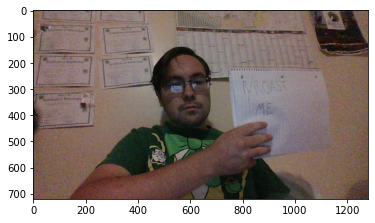

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
caption,result,attention_weights = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in caption:
    if i=="<unk>":
        caption.remove(i)

for i in real_caption:
    if i=="<unk>":
        real_caption.remove(i)

#remove <end> from result         
result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = caption
score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
print(f"BLEU-1 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-4 score: {score*100}")

print ('Real Caption:', real_caption)
print ('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.imshow(temp_image)

BLEU-1 score: 0
BLEU-2 score: 0
BLEU-3 score: 0
BLEU-4 score: 0
Real Caption: ok now take one not in <unk> mirror
Predicted Caption: you look like the smell of <end>


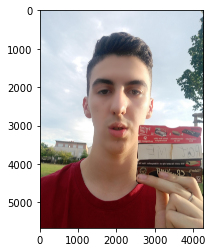

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
caption,result,attention_weights = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in caption:
    if i=="<unk>":
        caption.remove(i)

for i in real_caption:
    if i=="<unk>":
        real_caption.remove(i)

#remove <end> from result         
result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = caption
score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
print(f"BLEU-1 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-4 score: {score*100}")

print ('Real Caption:', real_caption)
print ('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.imshow(temp_image)

BLEU-1 score: 0
BLEU-2 score: 0
BLEU-3 score: 0
BLEU-4 score: 0
Real Caption: indian hate story
Predicted Caption: you look like you got across the border in this <end>


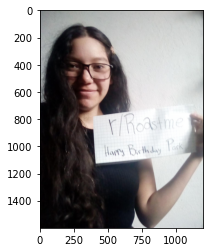

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
caption,result,attention_weights = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in caption:
    if i=="<unk>":
        caption.remove(i)

for i in real_caption:
    if i=="<unk>":
        real_caption.remove(i)

#remove <end> from result         
result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = caption
score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
print(f"BLEU-1 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-4 score: {score*100}")

print ('Real Caption:', real_caption)
print ('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.imshow(temp_image)

BLEU-1 score: 0
BLEU-2 score: 0
BLEU-3 score: 0
BLEU-4 score: 0
Real Caption: sheep can say no now
Predicted Caption: cheer up dump you more successful <end>


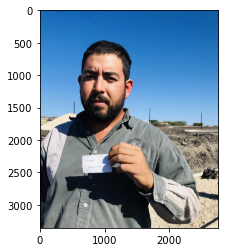

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
caption,result,attention_weights = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in caption:
    if i=="<unk>":
        caption.remove(i)

for i in real_caption:
    if i=="<unk>":
        real_caption.remove(i)

#remove <end> from result         
result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = caption
score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
print(f"BLEU-1 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-4 score: {score*100}")

print ('Real Caption:', real_caption)
print ('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.imshow(temp_image)

BLEU-1 score: 3.7188360024738305
BLEU-2 score: 9.109250643152444
BLEU-3 score: 13.035056022389313
BLEU-4 score: 14.256747717620566
Real Caption: enjoy the slide girl its the best you re gonna get with face like that
Predicted Caption: that cat is not this <end>


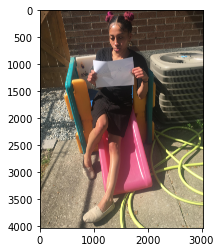

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
caption,result,attention_weights = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in caption:
    if i=="<unk>":
        caption.remove(i)

for i in real_caption:
    if i=="<unk>":
        real_caption.remove(i)

#remove <end> from result         
result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = caption
score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
print(f"BLEU-1 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-4 score: {score*100}")

print ('Real Caption:', real_caption)
print ('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.imshow(temp_image)

BLEU-1 score: 8.333333333333332
BLEU-2 score: 28.867513459481287
BLEU-3 score: 47.45102806263551
BLEU-4 score: 53.7284965911771
Real Caption: he looks pretty <unk> already
Predicted Caption: this the guy who alot because he doesn have any friends <end>


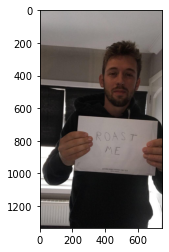

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
caption,result,attention_weights = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in caption:
    if i=="<unk>":
        caption.remove(i)

for i in real_caption:
    if i=="<unk>":
        real_caption.remove(i)

#remove <end> from result         
result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = caption
score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
print(f"BLEU-1 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-4 score: {score*100}")

print ('Real Caption:', real_caption)
print ('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.imshow(temp_image)

BLEU-1 score: 0
BLEU-2 score: 0
BLEU-3 score: 0
BLEU-4 score: 0
Real Caption: you will burn last because you definitely live in basement
Predicted Caption: resting pug face <end>


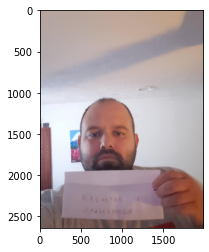

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
caption,result,attention_weights = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in caption:
    if i=="<unk>":
        caption.remove(i)

for i in real_caption:
    if i=="<unk>":
        real_caption.remove(i)

#remove <end> from result         
result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = caption
score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
print(f"BLEU-1 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-4 score: {score*100}")

print ('Real Caption:', real_caption)
print ('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.imshow(temp_image)

BLEU-1 score: 8.075860719786215
BLEU-2 score: 6.38452848520282
BLEU-3 score: 10.118795733272012
BLEU-4 score: 11.353475548043166
Real Caption: you know when you look at your face in the back of spoon
Predicted Caption: you look like behind <end>


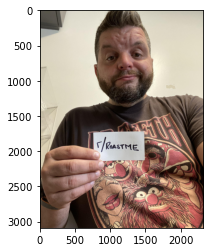

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
caption,result,attention_weights = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in caption:
    if i=="<unk>":
        caption.remove(i)

for i in real_caption:
    if i=="<unk>":
        real_caption.remove(i)

#remove <end> from result         
result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = caption
score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
print(f"BLEU-1 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-4 score: {score*100}")

print ('Real Caption:', real_caption)
print ('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.imshow(temp_image)

BLEU-1 score: 22.22222222222222
BLEU-2 score: 47.14045207910317
BLEU-3 score: 63.684866956664344
BLEU-4 score: 68.65890479690393
Real Caption: dumb hair is not replacement for personality
Predicted Caption: wonder what he is hiding inside his hair <end>


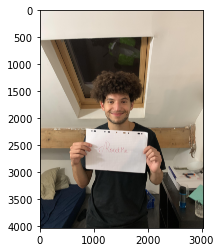

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
caption,result,attention_weights = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in caption:
    if i=="<unk>":
        caption.remove(i)

for i in real_caption:
    if i=="<unk>":
        real_caption.remove(i)

#remove <end> from result         
result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = caption
score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
print(f"BLEU-1 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-4 score: {score*100}")

print ('Real Caption:', real_caption)
print ('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.imshow(temp_image)

BLEU-1 score: 0
BLEU-2 score: 0
BLEU-3 score: 0
BLEU-4 score: 0
Real Caption: finally boy george transition is complete
Predicted Caption: how many dead bodies do you ll ever yourself <end>


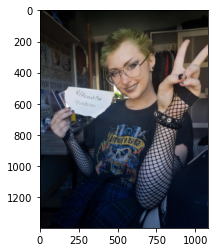

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
caption,result,attention_weights = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in caption:
    if i=="<unk>":
        caption.remove(i)

for i in real_caption:
    if i=="<unk>":
        real_caption.remove(i)

#remove <end> from result         
result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = caption
score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
print(f"BLEU-1 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-4 score: {score*100}")

print ('Real Caption:', real_caption)
print ('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.imshow(temp_image)

BLEU-1 score: 0
BLEU-2 score: 0
BLEU-3 score: 0
BLEU-4 score: 0
Real Caption: <unk>
Predicted Caption: you look like you run out but you are to another disappointment <end>


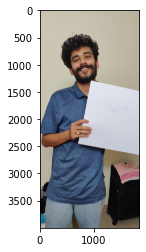

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
caption,result,attention_weights = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in caption:
    if i=="<unk>":
        caption.remove(i)

for i in real_caption:
    if i=="<unk>":
        real_caption.remove(i)

#remove <end> from result         
result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = caption
score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
print(f"BLEU-1 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-4 score: {score*100}")

print ('Real Caption:', real_caption)
print ('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.imshow(temp_image)

BLEU-1 score: 0
BLEU-2 score: 0
BLEU-3 score: 0
BLEU-4 score: 0
Real Caption: hair <unk> that clearly doesn include <unk> out those <unk> for eyebrows
Predicted Caption: incel whatever you say sir <end>


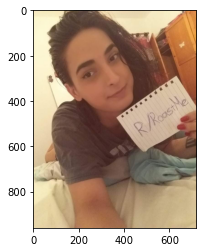

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
caption,result,attention_weights = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in caption:
    if i=="<unk>":
        caption.remove(i)

for i in real_caption:
    if i=="<unk>":
        real_caption.remove(i)

#remove <end> from result         
result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = caption
score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
print(f"BLEU-1 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-4 score: {score*100}")

print ('Real Caption:', real_caption)
print ('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.imshow(temp_image)

BLEU-1 score: 11.031211282307446
BLEU-2 score: 31.200977209684577
BLEU-3 score: 47.29183804803228
BLEU-4 score: 52.47357977607321
Real Caption: you look like you would suck dick for weed
Predicted Caption: you misspelled high because it just stop <end>


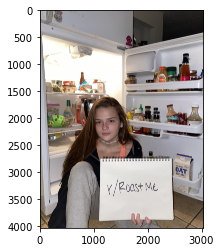

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
caption,result,attention_weights = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in caption:
    if i=="<unk>":
        caption.remove(i)

for i in real_caption:
    if i=="<unk>":
        real_caption.remove(i)

#remove <end> from result         
result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = caption
score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
print(f"BLEU-1 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-4 score: {score*100}")

print ('Real Caption:', real_caption)
print ('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.imshow(temp_image)

BLEU-1 score: 0
BLEU-2 score: 0
BLEU-3 score: 0
BLEU-4 score: 0
Real Caption: look at those virginity eye bags
Predicted Caption: looking like you love to make more worried about chemo <end>


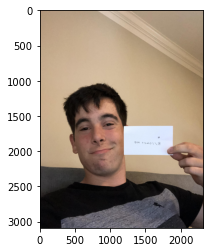

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
caption,result,attention_weights = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in caption:
    if i=="<unk>":
        caption.remove(i)

for i in real_caption:
    if i=="<unk>":
        real_caption.remove(i)

#remove <end> from result         
result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = caption
score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
print(f"BLEU-1 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-4 score: {score*100}")

print ('Real Caption:', real_caption)
print ('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.imshow(temp_image)

BLEU-1 score: 0
BLEU-2 score: 0
BLEU-3 score: 0
BLEU-4 score: 0
Real Caption: im not saying you are fat but bet you weigh <unk>
Predicted Caption: looks like the transition doesn fix my sex <end>


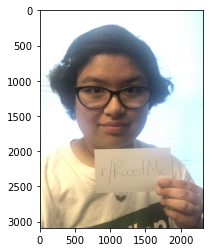

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
caption,result,attention_weights = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in caption:
    if i=="<unk>":
        caption.remove(i)

for i in real_caption:
    if i=="<unk>":
        real_caption.remove(i)

#remove <end> from result         
result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = caption
score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
print(f"BLEU-1 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-4 score: {score*100}")

print ('Real Caption:', real_caption)
print ('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.imshow(temp_image)

BLEU-1 score: 0
BLEU-2 score: 0
BLEU-3 score: 0
BLEU-4 score: 0
Real Caption: can tell your gender
Predicted Caption: stop in the addiction <end>


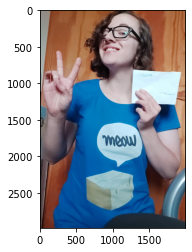

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
caption,result,attention_weights = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in caption:
    if i=="<unk>":
        caption.remove(i)

for i in real_caption:
    if i=="<unk>":
        real_caption.remove(i)

#remove <end> from result         
result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = caption
score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
print(f"BLEU-1 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-4 score: {score*100}")

print ('Real Caption:', real_caption)
print ('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.imshow(temp_image)

BLEU-1 score: 0
BLEU-2 score: 0
BLEU-3 score: 0
BLEU-4 score: 0
Real Caption: if <unk> had face this wouldn be the one
Predicted Caption: gay conan <end>


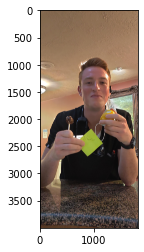

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
caption,result,attention_weights = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in caption:
    if i=="<unk>":
        caption.remove(i)

for i in real_caption:
    if i=="<unk>":
        real_caption.remove(i)

#remove <end> from result         
result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = caption
score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
print(f"BLEU-1 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-4 score: {score*100}")

print ('Real Caption:', real_caption)
print ('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.imshow(temp_image)

BLEU-1 score: 0
BLEU-2 score: 0
BLEU-3 score: 0
BLEU-4 score: 0
Real Caption: still got <unk> <unk> on your glasses
Predicted Caption: of semen was person <end>


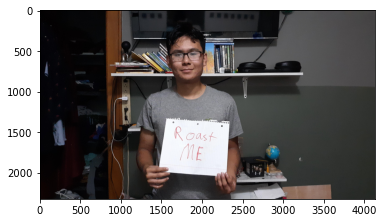

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
caption,result,attention_weights = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in caption:
    if i=="<unk>":
        caption.remove(i)

for i in real_caption:
    if i=="<unk>":
        real_caption.remove(i)

#remove <end> from result         
result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = caption
score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
print(f"BLEU-1 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-4 score: {score*100}")

print ('Real Caption:', real_caption)
print ('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.imshow(temp_image)

BLEU-1 score: 0
BLEU-2 score: 0
BLEU-3 score: 0
BLEU-4 score: 0
Real Caption: deep deep deep deep that all folks
Predicted Caption: you say you look like dick for head <end>


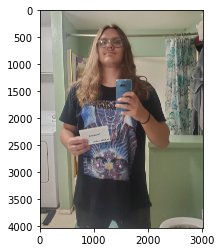

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
caption,result,attention_weights = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in caption:
    if i=="<unk>":
        caption.remove(i)

for i in real_caption:
    if i=="<unk>":
        real_caption.remove(i)

#remove <end> from result         
result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = caption
score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
print(f"BLEU-1 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-4 score: {score*100}")

print ('Real Caption:', real_caption)
print ('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.imshow(temp_image)